This file contains functions to visualize and select the best training curves from our experiments.

In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('cmu_paper')

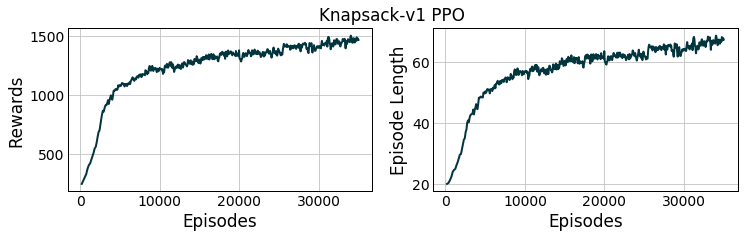

/home/christian/ray_results/PPO/PPO_Knapsack-v1_0a0c1d2d_7_entropy_coeff=0.001,lr=0.0001,vf_share_layers=False_2020-04-01_02-48-14vl_32i4a


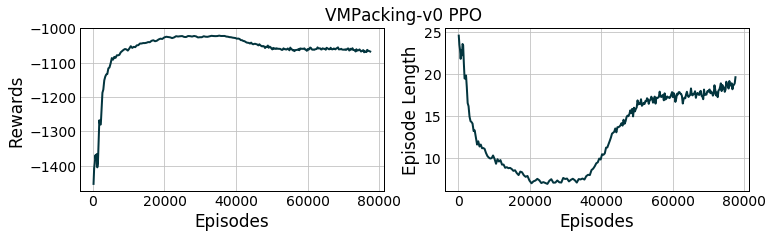

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7f1_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-13_20-56-379cb614q8


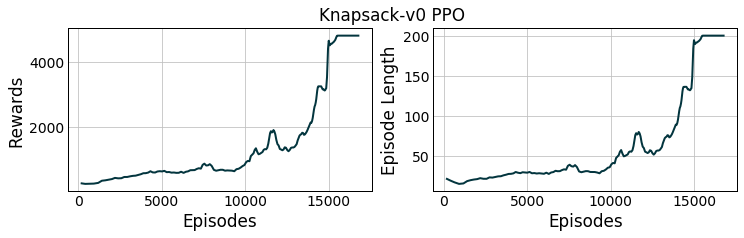

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da3_1_lr=0.001,vf_share_layers=True_2020-03-21_16-39-26_z6_97l8


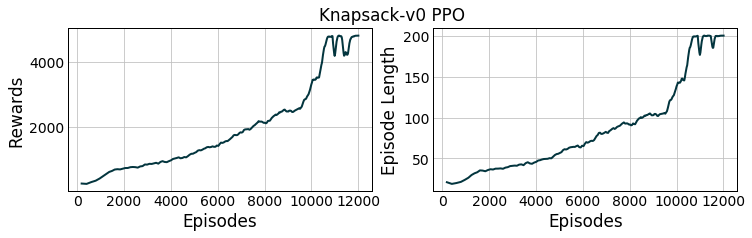

/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da4_2_lr=0.0001,vf_share_layers=True_2020-03-21_17-13-03j4saa4bw


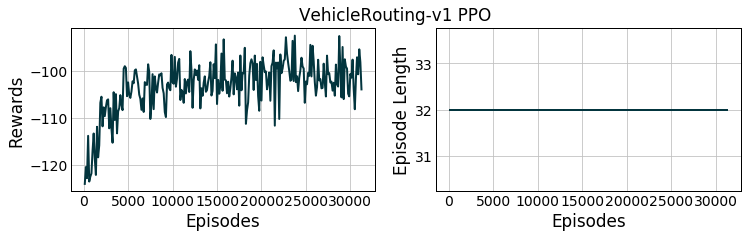

/home/christian/ray_results/PPO/PPO_VehicleRouting-v1_238b7de5_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-02_20-20-4547ljic2_


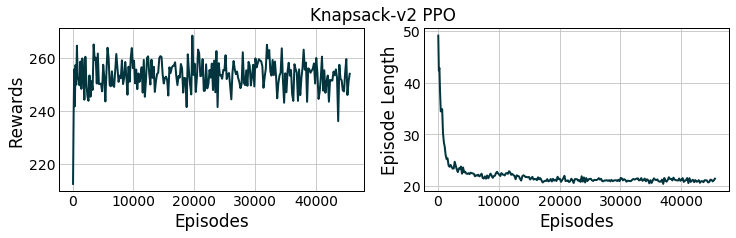

/home/christian/ray_results/PPO/PPO_Knapsack-v2_56320e97_5_entropy_coeff=0.001,lr=1e-06,vf_share_layers=False_2020-04-14_19-27-41ejtyiz3d


In [2]:
# Get data from results folders
result_path = '../or_gym/benchmarks/results'
results = os.listdir(result_path)
envs = set([i.split('_')[0] for i in results])
for env in envs:
    result_data = pd.DataFrame()
    for data_path in results:
        if env in data_path:
            _result_data = pd.read_csv(
                os.path.join(result_path, data_path))
            result_data = pd.concat([result_data, _result_data])
            
    top_results = result_data.loc[
        result_data['episode_reward_mean']==result_data['episode_reward_mean'].max()]
    
    for _path in top_results['logdir']:
        algo_name = os.path.basename(_path).split('_')[0]
        train_data = pd.read_csv(_path + '/progress.csv')
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        ax[0].plot(train_data['episodes_total'], train_data['episode_reward_mean'])
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
#         ax[0].set_title(env + ' ' + algo_name)
        
        ax[1].plot(train_data['episodes_total'], train_data['episode_len_mean'])
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Episode Length')
        plt.suptitle(env + ' ' + algo_name)
#         plt.tight_layout()
        plt.show()
        print(_path)

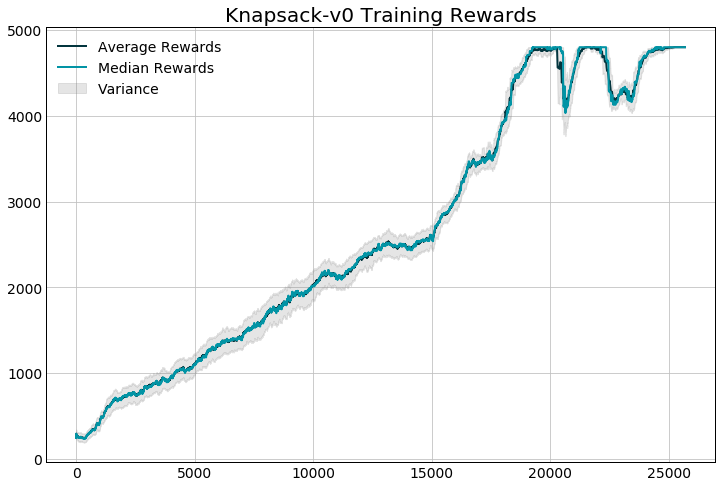

In [48]:
# Get episode totals
ep_stats = ['hist_stats/episode_reward']

for i in ep_stats:
    vals = None
    ep_vals = train_data[i].values
    for j in ep_vals:
        ep_vals = np.array(re.findall(r"[-+]?\d*\.\d+|\d+", j)).astype(float)
        if vals is None:
            vals = ep_vals.copy()
        else:
            vals = np.hstack([vals, ep_vals.copy()])

window = 100
reward_var = np.array([np.std(vals[i-window:i+1]) 
                       if i>window else np.std(vals[:i+1]) 
                       for i, j in enumerate(vals)])
med_reward = np.array([np.median(vals[i-window:i+1]) 
                       if i>window else np.median(vals[:i+1]) 
                       for i, j in enumerate(vals)])
ep_max = np.array([np.max(vals[i-window:i+1]) 
                       if i>window else np.max(vals[:i+1]) 
                       for i, j in enumerate(vals)])
ep_min = np.array([np.min(vals[i-window:i+1]) 
                       if i>window else np.min(vals[:i+1]) 
                       for i, j in enumerate(vals)])
mean_vals = np.array([np.mean(vals[i-window:i+1]) 
                       if i>window else np.mean(vals[:i+1]) 
                       for i, j in enumerate(vals)])

fill_max = np.where(mean_vals + reward_var<=ep_max, mean_vals+reward_var, ep_max)
fill_min = np.where(mean_vals - reward_var>0, mean_vals-reward_var, 0)

plt.figure(figsize=(12,8))
plt.plot(mean_vals, label='Average Rewards')
# plt.plot(med_reward, label='Median Rewards')
plt.fill_between(np.arange(mean_vals.shape[0]), fill_min, fill_max,
                 color='gray', alpha=0.2, label='Variance')
plt.title('Knapsack-v0 Training Rewards')
plt.legend()
plt.show()

In [41]:
data = pd.read_csv('../or_gym/benchmarks/results/VMPacking-v0_or_gym_tune_2020-04-13.csv')
data

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,info/learner/default_policy/entropy_coeff,config/entropy_coeff,config/env,config/env_config,config/lr,config/model,config/num_workers,config/vf_clip_param,config/vf_share_layers,logdir
0,-1003.493313,-1250.342241,-1097.462244,24.558282,163,4000,True,1000000,56812,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
1,-1004.183975,-1228.260401,-1110.124231,27.376712,146,4000,True,1000000,56183,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
2,-1004.846325,-1192.904492,-1070.930941,18.741784,213,4000,True,1000000,78604,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
3,-1002.134130,-1152.306792,-1067.583072,19.588235,204,4000,True,1000000,77533,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
4,-1000.920722,-1555.138960,-1148.324953,14.921933,269,4000,True,1000000,44089,250,...,0.010,0.010,VMPacking-v0,{'reuse_actors': True},0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
5,-1006.995235,-1641.756196,-1179.577573,16.196787,249,4000,True,1000000,42714,250,...,0.001,0.001,VMPacking-v0,{'reuse_actors': True},0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...


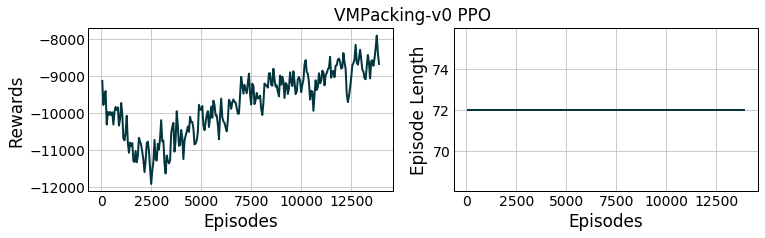

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af0_0_entropy_coeff=0.01,lambda=1,lr=1e-05,vf_share_layers=False_2020-04-16_20-58-20sjlbj8xx


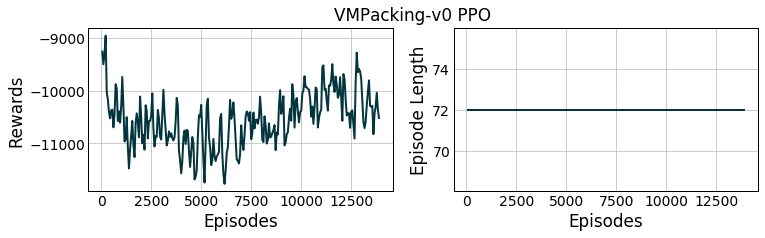

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af1_1_entropy_coeff=0.001,lambda=1,lr=1e-05,vf_share_layers=False_2020-04-16_20-58-20ypi8kcqs


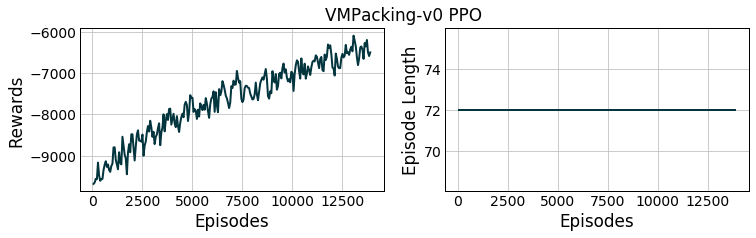

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af2_2_entropy_coeff=0.01,lambda=0.5,lr=1e-05,vf_share_layers=False_2020-04-16_20-58-20xz1cv7gh


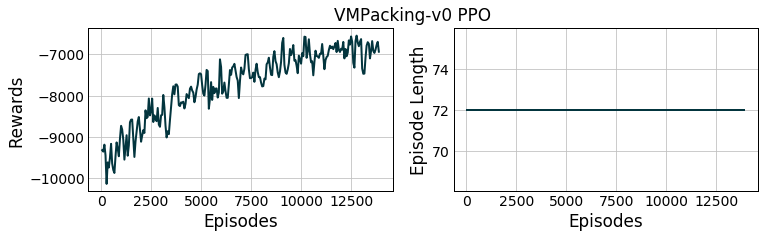

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af3_3_entropy_coeff=0.001,lambda=0.5,lr=1e-05,vf_share_layers=False_2020-04-16_21-23-07klu0n5g_


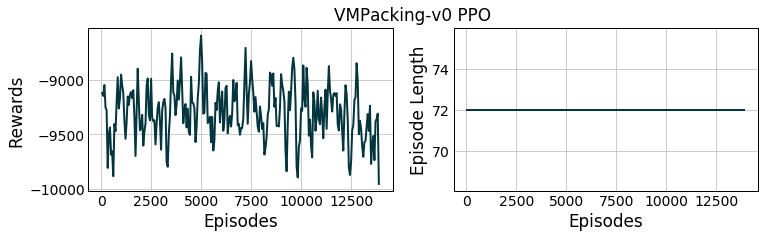

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af4_4_entropy_coeff=0.01,lambda=1,lr=1e-06,vf_share_layers=False_2020-04-16_21-23-071b78_srs


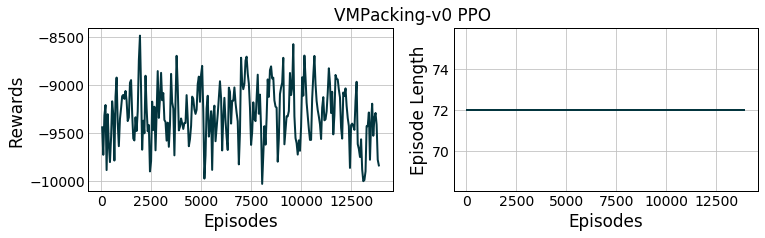

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af5_5_entropy_coeff=0.001,lambda=1,lr=1e-06,vf_share_layers=False_2020-04-16_21-48-59_vtbq4pw


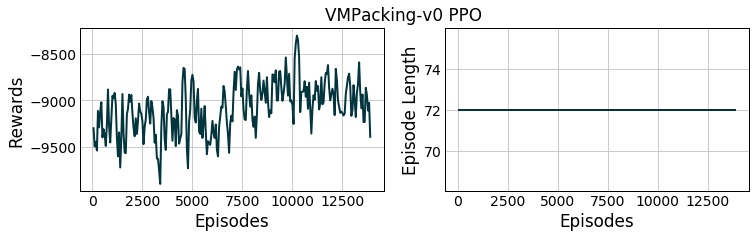

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af6_6_entropy_coeff=0.01,lambda=0.5,lr=1e-06,vf_share_layers=False_2020-04-16_21-48-59gb0iyckw


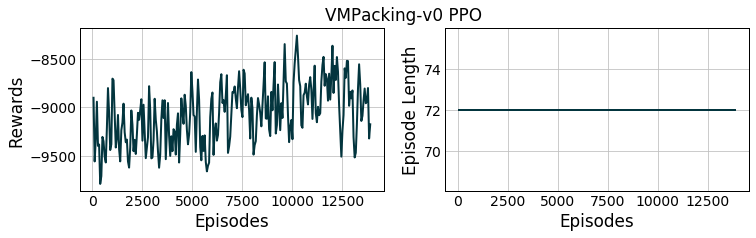

/home/christian/ray_results/PPO/PPO_VMPacking-v0_e96e1af7_7_entropy_coeff=0.001,lambda=0.5,lr=1e-06,vf_share_layers=False_2020-04-16_22-14-26br4q6yoq


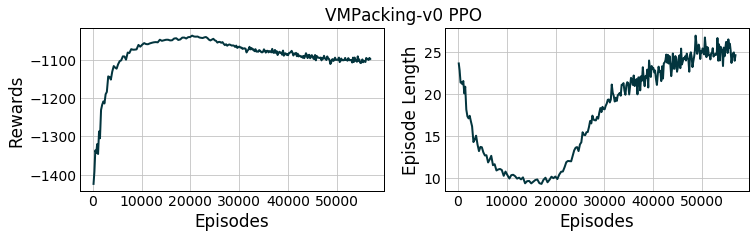

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7ee_0_entropy_coeff=0.01,lr=0.0001,vf_share_layers=False_2020-04-13_20-24-43olvo318z


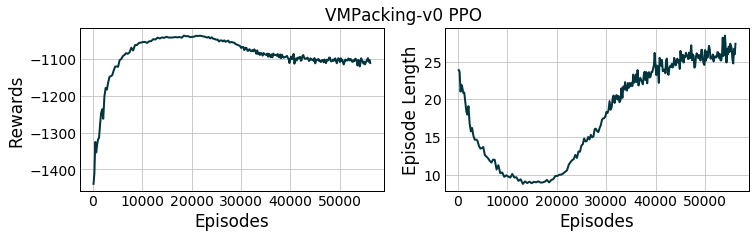

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7ef_1_entropy_coeff=0.001,lr=0.0001,vf_share_layers=False_2020-04-13_20-24-43x1l7yp3h


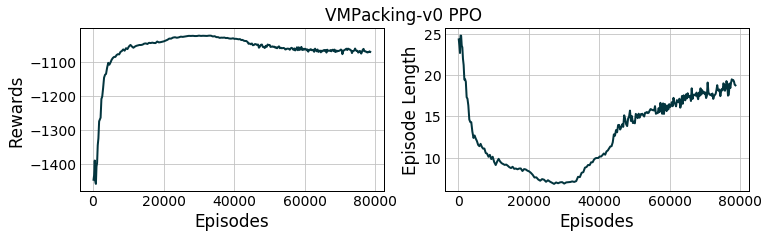

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7f0_2_entropy_coeff=0.01,lr=1e-05,vf_share_layers=False_2020-04-13_20-56-21wr9c9bs1


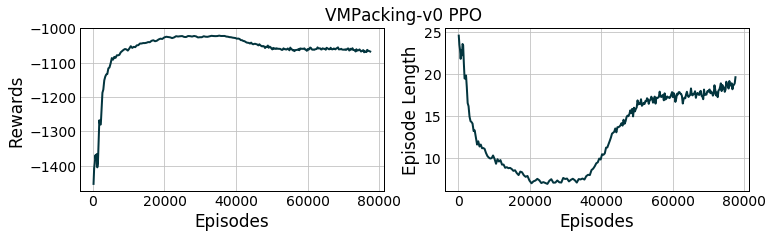

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7f1_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-13_20-56-379cb614q8


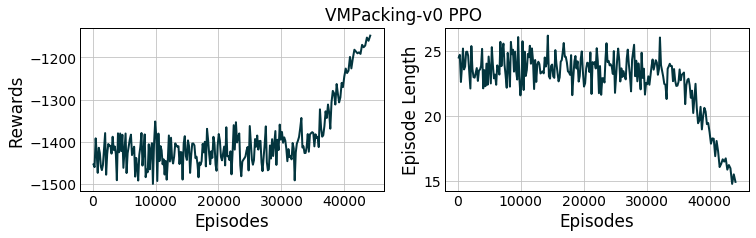

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7f2_4_entropy_coeff=0.01,lr=1e-06,vf_share_layers=False_2020-04-13_21-27-48d9usoa89


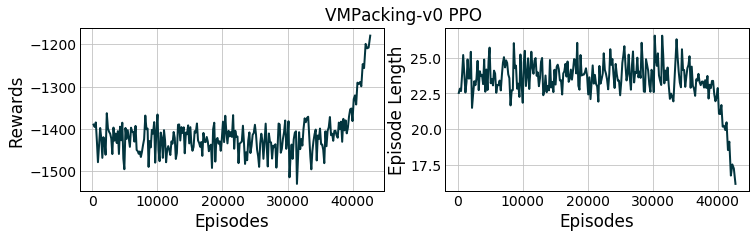

/home/christian/ray_results/PPO/PPO_VMPacking-v0_b86de7f3_5_entropy_coeff=0.001,lr=1e-06,vf_share_layers=False_2020-04-13_21-27-58b4s_71hq


In [3]:
result_path = '../or_gym/benchmarks/results'
results = os.listdir(result_path)
envs = set([i.split('_')[0] for i in results])
envs = ['VMPacking-v0']
for env in envs:
    result_data = pd.DataFrame()
    for data_path in results:
        if env in data_path:
            _result_data = pd.read_csv(
                os.path.join(result_path, data_path))
            result_data = pd.concat([result_data, _result_data])
            
    for _path in result_data['logdir']:
        algo_name = os.path.basename(_path).split('_')[0]
        train_data = pd.read_csv(_path + '/progress.csv')
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        ax[0].plot(train_data['episodes_total'], train_data['episode_reward_mean'])
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
#         ax[0].set_title(env + ' ' + algo_name)
        
        ax[1].plot(train_data['episodes_total'], train_data['episode_len_mean'])
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Episode Length')
        plt.suptitle(env + ' ' + algo_name)
#         plt.tight_layout()
        plt.show()
        print(_path)

In [145]:
result_data

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,config/entropy_coeff,config/env,config/env_config,config/lambda,config/lr,config/model,config/num_workers,config/vf_clip_param,config/vf_share_layers,logdir
0,-4453.388097,-15705.039091,-8667.351192,72.000000,56,4000,True,1000000,13888,250,...,0.010,VMPacking-v0,{},1.0,0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
1,-5928.836059,-16609.161149,-10518.946399,72.000000,56,4000,True,1000000,13888,250,...,0.001,VMPacking-v0,{},1.0,0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
2,-2636.913405,-12030.261226,-6505.323706,72.000000,56,4000,True,1000000,13888,250,...,0.010,VMPacking-v0,{},0.5,0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
3,-2849.728214,-12904.241210,-6934.958336,72.000000,56,4000,True,1000000,13888,250,...,0.001,VMPacking-v0,{},0.5,0.000010,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
4,-5946.672157,-16668.431643,-9950.094366,72.000000,56,4000,True,1000000,13888,250,...,0.010,VMPacking-v0,{},1.0,0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
5,-3491.603935,-17620.481460,-9842.691574,72.000000,56,4000,True,1000000,13888,250,...,0.001,VMPacking-v0,{},1.0,0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
6,-4274.214782,-15900.520058,-9389.673155,72.000000,56,4000,True,1000000,13888,250,...,0.010,VMPacking-v0,{},0.5,0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
7,-3644.931651,-14979.071806,-9174.232748,72.000000,56,4000,True,1000000,13888,250,...,0.001,VMPacking-v0,{},0.5,0.000001,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
0,-1003.493313,-1250.342241,-1097.462244,24.558282,163,4000,True,1000000,56812,250,...,0.010,VMPacking-v0,{'reuse_actors': True},NaN,0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...
1,-1004.183975,-1228.260401,-1110.124231,27.376712,146,4000,True,1000000,56183,250,...,0.001,VMPacking-v0,{'reuse_actors': True},NaN,0.000100,"{'custom_model': 'or_gym_tune', 'fcnet_activat...",2,10,False,/home/christian/ray_results/PPO/PPO_VMPacking-...


In [165]:
import matplotlib as mpl

In [168]:
mpl.get_configdir()

'/home/christian/.config/matplotlib'